#  Анализ и интерпретация результатов работы нейросетевых моделей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://github.com/TylerYep/torchinfo
* https://docs.pytorch.org/tutorials/intermediate/visualizing_gradients_tutorial.html
* https://github.com/johnmarktaylor91/torchlens
* https://captum.ai/docs/extension/integrated_gradients
* https://captum.ai/tutorials/House_Prices_Regression_Interpret
* https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
* https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html


## Задачи для совместного разбора

1\. Обсудите проблему анализа и интерпретации работы нейросетевых моделей. Рассмотрите готовые решения для этих задач.

## Задачи для самостоятельного решения

In [32]:
import pandas as pd
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torchlens as tl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torchlens')

<p class="task" id="1"></p>

1\. На основе файла `synthetic_coffee_health_10000.csv` создайте набор данных в смысле `torch.utils.data.Dataset`. Закодируйте все нечисловые переменные при помощи `LabelEncoder`. Целевая переменная - столбец `Health_Issues`. Разделите датасет на обучающее и тестовое множество.

- [ ] Проверено на семинаре

In [33]:
class CoffeeHealthDataset(Dataset):
    """
    Класс для работы с датасетом о влиянии кофе на здоровье.
    Выполняет загрузку, кодирование категориальных признаков и
    предоставляет доступ к данным в формате тензоров PyTorch.
    """
    def __init__(self, csv_path: str):
        """
        Инициализация датасета.

        Args:
            csv_path (str): Путь к CSV файлу с данными.
        """
        try:
            self.df = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"Ошибка: Файл {csv_path} не найден.")
            # Создаем пустой DataFrame, чтобы избежать дальнейших ошибок при инициализации
            self.df = pd.DataFrame()
            self.features = torch.empty(0)
            self.target = torch.empty(0)
            return

        self._preprocess_data()

        # Отделяем признаки от целевой переменной
        features_df = self.df.drop('Health_Issues', axis=1)
        target_series = self.df['Health_Issues']

        # Конвертируем в тензоры PyTorch
        self.features = torch.tensor(features_df.values, dtype=torch.float32)
        self.target = torch.tensor(target_series.values, dtype=torch.long)
        self.feature_names = features_df.columns.tolist()


    def _preprocess_data(self):
        """
        Выполняет кодирование нечисловых признаков с помощью LabelEncoder.
        """
        for col in self.df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])

    def __len__(self):
        """
        Возвращает общее количество сэмплов в датасете.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Возвращает один сэмпл (признаки и цель) по указанному индексу.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.features[idx], self.target[idx]

    def get_splits(self, test_size=0.2, random_state=42):
        """
        Разделяет датасет на обучающую и тестовую выборки.

        Args:
            test_size (float): Доля тестовой выборки (от 0 до 1).
            random_state (int): Сид для воспроизводимости разделения.

        Returns:
            A tuple of (train_dataset, test_dataset)
        """
        if len(self) == 0:
            return None, None

        indices = list(range(len(self)))
        
        # Используем stratify для сохранения распределения классов в выборках
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=self.target.numpy()
        )

        train_dataset = torch.utils.data.Subset(self, train_indices)
        test_dataset = torch.utils.data.Subset(self, test_indices)
        
        return train_dataset, test_dataset

In [34]:
FILE_PATH = 'synthetic_coffee_health_10000.csv'

full_dataset = CoffeeHealthDataset(FILE_PATH)


train_data, test_data = full_dataset.get_splits(test_size=0.2)

print(f"Общий размер датасета: {len(full_dataset)}")
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print("-" * 30)

features, target = train_data[0]
print("Пример данных из обучающей выборки:")
print(f"Признаки (тип: {features.dtype}, форма: {features.shape}):\n{features}")
print(f"Целевая переменная (тип: {target.dtype}, форма: {target.shape}): {target}")
print("-" * 30)
print(f"Названия признаков:")
print(*full_dataset.feature_names, sep='\n')

Общий размер датасета: 10000
Размер обучающей выборки: 8000
Размер тестовой выборки: 2000
------------------------------
Пример данных из обучающей выборки:
Признаки (тип: torch.float32, форма: torch.Size([15])):
tensor([5.7750e+03, 3.8000e+01, 0.0000e+00, 5.0000e+00, 2.3000e+00, 2.1940e+02,
        8.8000e+00, 0.0000e+00, 2.1900e+01, 8.0000e+01, 1.0000e+00, 6.7000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00])
Целевая переменная (тип: torch.int64, форма: torch.Size([])): 3
------------------------------
Названия признаков:
ID
Age
Gender
Country
Coffee_Intake
Caffeine_mg
Sleep_Hours
Sleep_Quality
BMI
Heart_Rate
Stress_Level
Physical_Activity_Hours
Occupation
Smoking
Alcohol_Consumption


<p class="task" id="2"></p>

2\. Опишите нейросетевую модель, имеющую следующую структуру:

```
NestedSequentialModel(
  (layer1): Sequential(
    (0): Linear
    (1): ReLU
    (2): Linear
    (3): ReLU
  )
  (layer2): Sequential(
    (0): Linear
    (1): ReLU
    (2): Linear
  )
)
```
Используя пакет `torchinfo`, выведите на экран основную информацию о данной модели: количество и размер слоев, размеры промежуточных выходов, занимаемую память и т.д.


- [ ] Проверено на семинаре

In [35]:
class NestedSequentialModel(nn.Module):
    """
    Нейросетевая модель с вложенной структурой Sequential-слоев,
    согласно заданию.
    """
    def __init__(self, input_features=11, num_classes=2):
        """
        Инициализация модели.

        Args:
            input_features (int): Количество входных признаков.
            num_classes (int): Количество выходных классов.
        """
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        """
        Прямой проход данных через модель.
        """
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [36]:
INPUT_FEATURES = len(full_dataset.feature_names)
BATCH_SIZE = 16

model = NestedSequentialModel(input_features=INPUT_FEATURES)

summary(model, input_size=(BATCH_SIZE, INPUT_FEATURES))

Layer (type:depth-idx)                   Output Shape              Param #
NestedSequentialModel                    [16, 2]                   --
├─Sequential: 1-1                        [16, 32]                  --
│    └─Linear: 2-1                       [16, 64]                  1,024
│    └─ReLU: 2-2                         [16, 64]                  --
│    └─Linear: 2-3                       [16, 32]                  2,080
│    └─ReLU: 2-4                         [16, 32]                  --
├─Sequential: 1-2                        [16, 2]                   --
│    └─Linear: 2-5                       [16, 16]                  528
│    └─ReLU: 2-6                         [16, 16]                  --
│    └─Linear: 2-7                       [16, 2]                   34
Total params: 3,666
Trainable params: 3,666
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 

<p class="task" id="3"></p>

3\. Выберите один батч размера 16 из созданного датасета. Используя пакет `torchlens`:
* визуализируйте структуру модели
* получите результаты всех промежуточных вычислений
* получите градиенты по всем слоям модели (используйте любую функцию потерь, адекватную для данной задачи)
* визуализируйте для каждого слоя модели среднее из абсолютных значений координат тензора градиента.



- [ ] Проверено на семинаре

--- Визуализация структуры модели и промежуточных вычислений ---


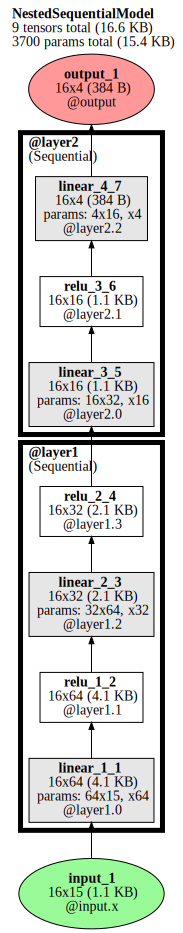

Log of NestedSequentialModel forward pass:
	Random seed: 2335639722
	Time elapsed: 1.267s (1.263s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- no branching
		- no conditional (if-then) branching
		- 9 total modules
	Tensor info:
		- 9 total tensors (16.6 KB) computed in forward pass.
		- 9 tensors (16.6 KB) with saved activations.
	Parameters: 4 parameter operations (3700 params total; 15.4 KB)
	Module Hierarchy:
		layer1
		    layer1.0, layer1.1, layer1.2, layer1.3
		layer2
		    layer2.0, layer2.1, layer2.2
	Layers (all have saved activations):
		  (0) input_1 
		  (1) linear_1_1 
		  (2) relu_1_2 
		  (3) linear_2_3 
		  (4) relu_2_4 
		  (5) linear_3_5 
		  (6) relu_3_6 
		  (7) linear_4_7 
		  (8) output_1 


--- Вычисление и визуализация градиентов ---


AttributeError: 'ModelHistory' object has no attribute 'plot_gradient_summary'

In [ ]:
# 2. Используем torchlens для анализа
print("--- Визуализация структуры модели и промежуточных вычислений ---")

# Логгируем прямой проход, чтобы получить структуру и выходы слоев
# Указываем слои, которые хотим проанализировать
model_history = tl.log_forward_pass(
    model, 
    features, 
    layers_to_save='all',
    vis_opt='unrolled'
)

# Выводим информацию, полученную после прямого прохода
display(model_history)

# 3. Получение градиентов
print("\n--- Вычисление и визуализация градиентов ---")

# Определяем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# Логгируем обратный проход для вычисления градиентов
# tl.(model_history, loss_fn, target)

# 4. Визуализация градиентов
# Используем встроенную функцию torchlens для построения графика
# средних абсолютных значений градиентов
fig = model_history.plot_gradient_summary(
    stat='mean', 
    abs_val=True, 
    title='Среднее абсолютное значение градиента по слоям',
    figsize=(12, 6)
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<p class="task" id="4"></p>

4\. Обучите созданную модель. Используя обученную модель и пакет `captum`, оцените важность признаков для каждого примера тестовой выборки, используя алгоритм `IntegratedGradients`. Визуализируйте полученные результаты, просуммировав по наблюдениям значения коэффициентов важности для каждого признака.

- [ ] Проверено на семинаре

<p class="task" id="5"></p>

5\. Используя алгоритм `DeepExlainer` из пакета `shap`, рассчитайте shap-значения для одного случайно выбранного примера тестовой выборки. В качестве репрезентативного множества используйте набор из 50 случайных наблюдений обучающей выборки. Визуализируйте несколько стандартных графиков, которые позволяет строить пакет `shap`, и дайте текстовое описание к каждому из них. 



- [ ] Проверено на семинаре